# SNN Baseline Classifier - Two-Layer Architecture 

**Goal**: Train an optimized two-layer Spiking Neural Network for BEST performance

**Architecture**: 28 → 56 → 42 → 2 (TWO hidden layers - OPTIMAL)
- **28 features**: Optimal balance (13.7:1 sample-to-feature ratio)
- **Hidden layer 1**: 56 neurons (2× features)
- **Hidden layer 2**: 42 neurons (1.5× features)  
- **Output**: 2 classes (Control vs PD)


## 1. Configuration & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import sys
from datetime import datetime
from scipy import signal
import joblib
import copy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler, RobustScaler

# Add modules to path
sys.path.append(str(Path.cwd() / 'modules'))
from modules.path_module import *
from modules.feature_extraction import *
from modules.processing_module import *
from modules.snn_models import *  

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to: {RANDOM_SEED}")

Using device: cpu
Random seed set to: 123


## 2. Load Feature Configuration

In [2]:
config_path = Path('results/snn/optimal_feature_config_comprehensive.json')
with open(config_path, 'r') as f:
    feature_config = json.load(f)

print(f"\nBand Distribution:")
for band, count in feature_config['band_distribution'].items():
    pct = count / feature_config['n_features'] * 100
    print(f"  {band.capitalize():<8}: {count:>2} features ({pct:>5.1f}%)")
print(f"\nSelected Features:")
for i, fname in enumerate(feature_config['feature_names'], 1):
    print(f"  {i:2d}. {fname}")


Band Distribution:
  Theta   : 17 features ( 60.7%)
  Gamma   :  3 features ( 10.7%)
  Alpha   :  3 features ( 10.7%)
  Broadband:  3 features ( 10.7%)
  Beta    :  1 features (  3.6%)
  Delta   :  1 features (  3.6%)

Selected Features:
   1. gamma_ch19
   2. theta_ch43
   3. theta_ch42
   4. theta_ch12
   5. theta_ch13
   6. theta_ch46
   7. gamma_ch48
   8. theta_ch38
   9. theta_ch8
  10. theta_ch39
  11. theta_ch15
  12. theta_ch44
  13. beta_ch19
  14. theta_ch11
  15. theta_ch45
  16. delta_ch19
  17. theta_ch51
  18. theta_ch6
  19. theta_ch14
  20. theta_ch37
  21. alpha_ch39
  22. theta_ch40
  23. entropy_ch18
  24. alpha_ch8
  25. entropy_ch0
  26. alpha_ch23
  27. gamma_ch31
  28. entropy_ch36


## 3. Load Features from Raw Data

In [3]:
# Load processed data
processed_path = processed_datapath()
train_data = joblib.load(processed_path / 'train_data.pkl')
val_data = joblib.load(processed_path / 'val_data.pkl')
test_data = joblib.load(processed_path / 'test_data.pkl')

print(f"Loaded processed data:")
print(f"  Train: {len(train_data)} segments")
print(f"  Val: {len(val_data)} segments")
print(f"  Test: {len(test_data)} segments")


Loaded processed data:
  Train: 384 segments
  Val: 120 segments
  Test: 156 segments


In [4]:
# Extract features 
X_train_raw, y_train, _ = extract_features_from_dataset(
    train_data,
    feature_config=feature_config,
    feature_type='enhanced'  
)
X_val_raw, y_val, _ = extract_features_from_dataset(
    val_data,
    feature_config=feature_config,
    feature_type='enhanced' 
)
X_test_raw, y_test, _ = extract_features_from_dataset(
    test_data,
    feature_config=feature_config,
    feature_type='enhanced'
)

## 4. Normalize Features

In [5]:
# Normalize features using standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print("Features normalized using StandardScaler")
print(f"  Train shape: {X_train.shape}")
print(f"  Val shape: {X_val.shape}")
print(f"  Test shape: {X_test.shape}")

Features normalized using StandardScaler
  Train shape: (384, 28)
  Val shape: (120, 28)
  Test shape: (156, 28)


## 5. Prepare Data Loaders

In [6]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders - MEMRISTOR-AWARE batch size
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data loaders created:")
print(f"  Batch size: {batch_size} (memristor-aware)")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Data loaders created:
  Batch size: 32 (memristor-aware)
  Train batches: 12
  Val batches: 4
  Test batches: 5


## 6. Creates SNN model

In [7]:
# Create model
num_features = X_train.shape[1]  
hidden1_size = 56
hidden2_size = 42

model = SNN(
    num_features=num_features,
    num_classes=2,
    num_steps=35,
    hidden1_size=hidden1_size,
    hidden2_size=hidden2_size,
    dropout=0.4 
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"SNN model created with {total_params} parameters.")

SNN model created with 4104 parameters.


## 7. SNN Training Configuration 


In [8]:
learning_rate = 0.0001       
num_epochs = 100
weight_decay = 0.01           
dropout_rate = 0.4           
label_smoothing = 0.0

print(f"  Learning rate: {learning_rate} (CONSTANT - no scheduler)")
print(f"  Weight decay: {weight_decay} (strong L2 regularization)")
print(f"  Dropout: {dropout_rate} (sweet spot)")
print(f"  Label smoothing: {label_smoothing}")
print(f"  Epochs: {num_epochs}")
print(f"  Early stopping: ENABLED (patience=20)")
print(f"  Gradient clipping: max_norm=1.0")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = None

# Early stopping
use_early_stopping = True
early_stopping_patience = 40


  Learning rate: 0.0001 (CONSTANT - no scheduler)
  Weight decay: 0.01 (strong L2 regularization)
  Dropout: 0.4 (sweet spot)
  Label smoothing: 0.0
  Epochs: 100
  Early stopping: ENABLED (patience=20)
  Gradient clipping: max_norm=1.0


## 8. Training Functions

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device, max_grad_norm=1.0):
    '''Train for one epoch with gradient clipping.'''
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        spk_rec, mem_rec = model(features)
        outputs = mem_rec.mean(0)


        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), 100 * correct / total


def validate(model, val_loader, criterion, device):
    '''Validate the model.'''
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)

            spk_rec, mem_rec = model(features)
            outputs = mem_rec.mean(0)

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(val_loader), 100 * correct / total

## 9. Train the Model (Memristor-Aware)

In [10]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Track best model
best_val_acc = 0.0
best_epoch = 0
best_model_state = None
epochs_without_improvement = 0

import time
start_time = time.time()

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Track best and early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        epochs_without_improvement = 0
        best_marker = " <- BEST"
    else:
        epochs_without_improvement += 1
        best_marker = ""

    print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
          f"Train: Loss={train_loss:.4f} Acc={train_acc:5.2f}% | "
          f"Val: Loss={val_loss:.4f} Acc={val_acc:5.2f}%{best_marker}")

    # Early stopping check
    if use_early_stopping and epochs_without_improvement >= early_stopping_patience:
        print(f"\n  Early stopping triggered at epoch {epoch+1}")
        print(f"  No improvement for {early_stopping_patience} epochs")
        print(f"  Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
        break

training_time = time.time() - start_time

# Load best model
model.load_state_dict(best_model_state)

print("="*80)
print(f"\nTraining completed!")
print(f"  Best epoch: {best_epoch}")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Total epochs trained: {epoch + 1}")
print(f"  Training time: {training_time/60:.2f} minutes")
print(f"  Final train accuracy: {history['train_acc'][-1]:.2f}%")
print(f"  Train-val gap: {history['train_acc'][-1] - best_val_acc:.2f}%")
if use_early_stopping and epochs_without_improvement >= early_stopping_patience:
    print(f"  Stopped early: Yes (saved {num_epochs - (epoch + 1)} epochs)")
else:
    print(f"  Stopped early: No")

print("="*80)

Epoch [  1/100] | Train: Loss=0.9374 Acc=48.18% | Val: Loss=0.9974 Acc=43.33% <- BEST
Epoch [  2/100] | Train: Loss=0.9274 Acc=49.22% | Val: Loss=0.9876 Acc=43.33%
Epoch [  3/100] | Train: Loss=0.9083 Acc=49.74% | Val: Loss=0.9776 Acc=43.33%
Epoch [  4/100] | Train: Loss=0.8897 Acc=51.30% | Val: Loss=0.9695 Acc=42.50%
Epoch [  5/100] | Train: Loss=0.8784 Acc=52.08% | Val: Loss=0.9594 Acc=41.67%
Epoch [  6/100] | Train: Loss=0.8621 Acc=52.08% | Val: Loss=0.9486 Acc=42.50%
Epoch [  7/100] | Train: Loss=0.8440 Acc=53.12% | Val: Loss=0.9468 Acc=42.50%
Epoch [  8/100] | Train: Loss=0.8324 Acc=53.12% | Val: Loss=0.9301 Acc=42.50%
Epoch [  9/100] | Train: Loss=0.8092 Acc=53.65% | Val: Loss=0.9134 Acc=42.50%
Epoch [ 10/100] | Train: Loss=0.7839 Acc=53.91% | Val: Loss=0.8961 Acc=43.33%
Epoch [ 11/100] | Train: Loss=0.7666 Acc=54.69% | Val: Loss=0.8837 Acc=43.33%
Epoch [ 12/100] | Train: Loss=0.7457 Acc=56.77% | Val: Loss=0.8626 Acc=46.67% <- BEST
Epoch [ 13/100] | Train: Loss=0.7165 Acc=56.25% 

## 10. Visualize Training History

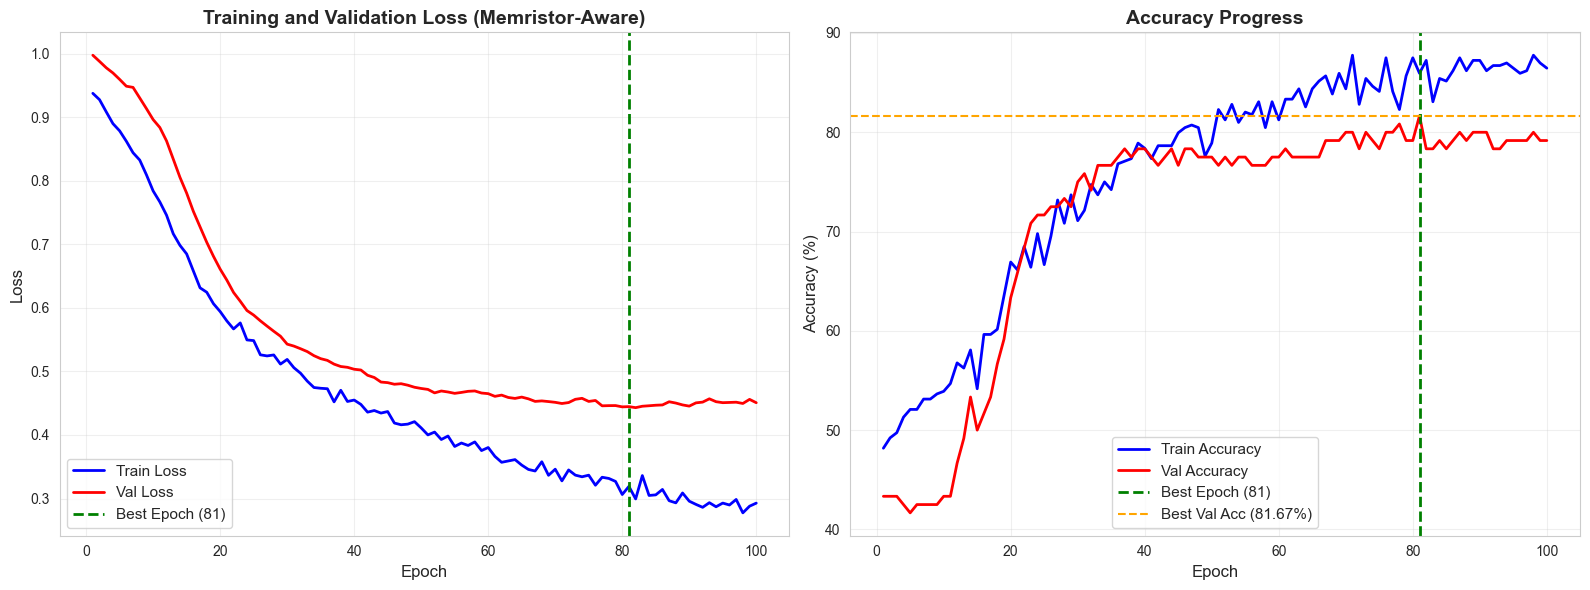

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss (Memristor-Aware)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
axes[1].axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, label=f'Best Epoch ({best_epoch})')
axes[1].axhline(y=best_val_acc, color='orange', linestyle='--', linewidth=1.5, label=f'Best Val Acc ({best_val_acc:.2f}%)')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Progress', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/snn/aware_baseline_training_history.png', dpi=300, bbox_inches='tight')
plt.show()



## 11. Evaluate on Test Set

In [12]:
def evaluate_model(model, test_loader, device):
    '''Comprehensive evaluation.'''
    model.eval()

    all_labels = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)

            spk_rec, mem_rec = model(features)
            outputs = mem_rec.mean(0)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_scores.extend(probs[:, 1].cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_scores)

# Evaluate on test set
print("Evaluating on test set...")
test_labels, test_preds, test_scores = evaluate_model(model, test_loader, device)

test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds),
    'recall': recall_score(test_labels, test_preds),
    'sensitivity': recall_score(test_labels, test_preds),
    'specificity': recall_score(test_labels, test_preds, pos_label=0),
    'f1_score': f1_score(test_labels, test_preds),
    'auc': roc_auc_score(test_labels, test_scores)
}

print("\n" + "="*80)
print("TEST METRICS (MEMRISTOR-AWARE BASELINE)")
print("="*80)
for metric, value in test_metrics.items():
    print(f"  {metric.capitalize():15s}: {value:.4f} ({value*100:.2f}%)")
print("="*80)


Evaluating on test set...

TEST METRICS (MEMRISTOR-AWARE BASELINE)
  Accuracy       : 0.8141 (81.41%)
  Precision      : 0.8235 (82.35%)
  Recall         : 0.8333 (83.33%)
  Sensitivity    : 0.8333 (83.33%)
  Specificity    : 0.7917 (79.17%)
  F1_score       : 0.8284 (82.84%)
  Auc            : 0.8975 (89.75%)


## 12. Confusion Matrix

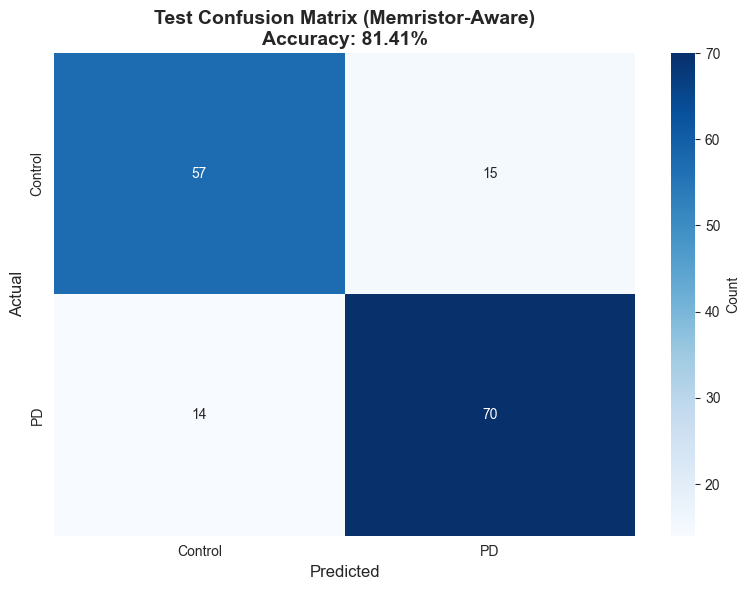


Classification Report:
              precision    recall  f1-score   support

     Control       0.80      0.79      0.80        72
          PD       0.82      0.83      0.83        84

    accuracy                           0.81       156
   macro avg       0.81      0.81      0.81       156
weighted avg       0.81      0.81      0.81       156



In [13]:
# Compute confusion matrix
test_cm = confusion_matrix(test_labels, test_preds)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Test Confusion Matrix (Memristor-Aware)\nAccuracy: {test_metrics["accuracy"]*100:.2f}%',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/snn/aware_baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Control', 'PD']))


# Patient-level_evaluation

In [14]:
def evaluate_patient_level(model, test_data, device):
    """
    Evaluate at patient level (not segment level)
    
    For each patient:
    1. Get all 12 segments
    2. Predict each segment
    3. Aggregate predictions (majority vote or avg probability)
    4. Compare to true label
    """
    model.eval()
    
    # Get unique patients
    test_patients = get_unique_patients(test_data)
    
    patient_correct = 0
    patient_predictions = []
    patient_labels = []
    
    print(f"\nPatient-Level Evaluation:")
    print(f"  Total patients: {len(test_patients)}")
    print(f"\nPer-patient results:")
    print(f"{'Patient':<10} {'True':<8} {'Pred':<8} {'Confidence':<12} {'Correct'}")
    print("="*60)
    
    for patient_id in test_patients:
        # Get all segments for this patient
        patient_segments = reconstruct_patient(test_data, patient_id)
        true_label = patient_segments[0].label
        
        # Extract features and predict for each segment
        segment_probs = []
        for seg in patient_segments:
            # Extract all enhanced features (band power + entropy)
            all_features, _ = extract_all_features_enhanced(seg.data)
            
            # Select only optimal features (using config indices)
            selected_features = all_features[feature_config['selected_indices']]
            
            # Normalize
            features_scaled = scaler.transform([selected_features])
            features_tensor = torch.FloatTensor(features_scaled).to(device)
            
            # Predict
            with torch.no_grad():
                spk_rec, mem_rec = model(features_tensor)
                outputs = mem_rec.mean(0)
                probs = torch.softmax(outputs, dim=1)
                segment_probs.append(probs.cpu().numpy()[0])
        
        # Aggregate: Average probability across all segments
        avg_prob = np.mean(segment_probs, axis=0)
        pred_label = np.argmax(avg_prob)
        confidence = avg_prob[pred_label]
        
        # Check if correct
        correct = (pred_label == true_label)
        if correct:
            patient_correct += 1
        
        patient_predictions.append(pred_label)
        patient_labels.append(true_label)
        
        # Print result
        status = "✓" if correct else "✗"
        print(f"{patient_id:<10} {true_label:<8} {pred_label:<8} {confidence:>6.1%}       {status}")
    
    # Calculate patient-level metrics
    patient_acc = patient_correct / len(test_patients)
    
    # Detailed metrics
    from sklearn.metrics import classification_report, confusion_matrix
    
    print("\n" + "="*60)
    print(f"PATIENT-LEVEL ACCURACY: {patient_acc:.4f} ({patient_acc*100:.2f}%)")
    print("="*60)
    
    print("\nPatient-Level Classification Report:")
    print(classification_report(patient_labels, patient_predictions, 
                                target_names=['Control', 'PD']))
    
    print("\nPatient-Level Confusion Matrix:")
    patient_cm = confusion_matrix(patient_labels, patient_predictions)
    print(f"              Predicted")
    print(f"              Control  PD")
    print(f"Actual Control   {patient_cm[0,0]:3d}    {patient_cm[0,1]:3d}")
    print(f"       PD        {patient_cm[1,0]:3d}    {patient_cm[1,1]:3d}")
    
    # Compare with segment-level
    print("\nCOMPARISON:")
    print(f"  Segment-level accuracy: {test_metrics['accuracy']*100:.2f}%")
    print(f"  Patient-level accuracy: {patient_acc*100:.2f}%")
    print(f"  Difference: {(patient_acc - test_metrics['accuracy'])*100:+.2f}%")
    
    if patient_acc < test_metrics['accuracy']:
        print(f"Patient-level is LOWER (segments are correlated)")
    else:
        print(f"Patient-level is HIGHER (aggregation helps!)")
    
    return patient_acc, patient_labels, patient_predictions

# Run patient-level evaluation
patient_acc, patient_labels, patient_preds = evaluate_patient_level(model, test_data, device)


Patient-Level Evaluation:
  Total patients: 13

Per-patient results:
Patient    True     Pred     Confidence   Correct
C01        0        0         83.4%       ✓
C04        0        0         98.6%       ✓
C08        0        0         96.6%       ✓
C09        0        0         74.0%       ✓
C21        0        1         69.6%       ✗
C24        0        0         74.9%       ✓
P01        1        1         77.2%       ✓
P06        1        1         63.9%       ✓
P09        1        1         97.9%       ✓
P14        1        1         90.5%       ✓
P19        1        0         69.6%       ✗
P23        1        1         93.3%       ✓
P26        1        1         89.6%       ✓

PATIENT-LEVEL ACCURACY: 0.8462 (84.62%)

Patient-Level Classification Report:
              precision    recall  f1-score   support

     Control       0.83      0.83      0.83         6
          PD       0.86      0.86      0.86         7

    accuracy                           0.85        13
   macro av

## 13. Save Results

In [15]:
# Prepare results
results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': f'Two-Layer Memristor-Aware SNN ({num_features} features)',
    'num_parameters': total_params,
    'num_features': num_features,
    'feature_names': feature_config['feature_names'],
    'band_distribution': feature_config['band_distribution'],
    'hyperparameters': {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'use_early_stopping': use_early_stopping,
        'early_stopping_patience': early_stopping_patience,
        'use_scheduler': False,
        'architecture': f'{num_features} -> {hidden1_size} -> {hidden2_size} -> 2',
        'dropout': dropout_rate,
        'label_smoothing': label_smoothing,
        'num_steps': 25,
        'weight_decay': weight_decay,
        'gradient_clipping': 1.0
    },
    'training': {
        'best_epoch': best_epoch,
        'best_val_acc': float(best_val_acc),
        'final_train_acc': float(history['train_acc'][-1]),
        'train_val_gap': float(history['train_acc'][-1] - best_val_acc),
        'epochs_trained': epoch + 1,
        'training_time_minutes': training_time / 60
    },
    'test_metrics': {k: float(v) for k, v in test_metrics.items()}
}

# Save with descriptive filenames using actual feature count and architecture
results_path = Path('results/snn')
results_path.mkdir(parents=True, exist_ok=True)

with open(results_path / f'two_layer_{num_features}features_results.json', 'w') as f:
    json.dump(results, f, indent=4)

with open(results_path / f'two_layer_{num_features}features_training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

torch.save(model.state_dict(), results_path / f'two_layer_{num_features}features_model.pth')
